# Download Data

- Download data to the local environment
- Unzip data to `./Dataset/Images/` and `./Dataset/Masks/` directory

In [1]:
from IPython.display import clear_output
!gdown --folder 1JMt7qdKcukjz4yvo58VVFeybizpmxRqo
!7z x -tzip -o./Dataset/ ./Dataset/Masks.zip
!7z x -tzip -o./Dataset/ ./Dataset/Images.zip
clear_output()

# Imports

In [11]:
from IPython.display import clear_output
from glob import glob
import os
from os import path
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.io import read_image, ImageReadMode
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import Progbar
# Model
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, DeepLabV3_MobileNet_V3_Large_Weights

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

# Utility Functions

In [5]:
def show(a, b):
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(a.permute(1, 2, 0).type(torch.uint8).cpu(), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(b.permute(1, 2, 0).type(torch.uint8).cpu(), cmap="gray")
    plt.axis("off")

# Dataset

In [6]:
class FlameSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_transform=None, mask_transform=None):
        super().__init__()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        
        self.img_transform = img_transform
        self.mask_transform = mask_transform

        self.filenames = self.get_filenames()

    def remove_ext(self, filenames):
        return [f.split(".")[0] for f in filenames]

    def get_filenames(self):
        images = self.remove_ext(os.listdir(self.image_dir))
        masks = self.remove_ext(os.listdir(self.mask_dir))

        if set(images) != set(masks):
            raise Exception("Filename mismatch in Images and Masks")

        return images

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            raise Exception("Slice passed instead of an index")
        
        filename = self.filenames[idx]
        image_path = path.join(self.image_dir, filename)
        mask_path = path.join(self.mask_dir, filename)

        image = read_image(image_path + ".jpg", ImageReadMode.RGB).type(torch.float).to(device)
        mask = read_image(mask_path + ".png", ImageReadMode.GRAY).type(torch.float).to(device)

        if self.img_transform:
            image = self.img_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

## Visualizing Data

In [7]:
IMAGE_DIR = "./Dataset/Images"
MASK_DIR = "./Dataset/Masks"

dataset = FlameSegDataset(IMAGE_DIR, MASK_DIR)

FLAME Segmentation Dataset has 2003 instances.

In [8]:
len(dataset)

2003

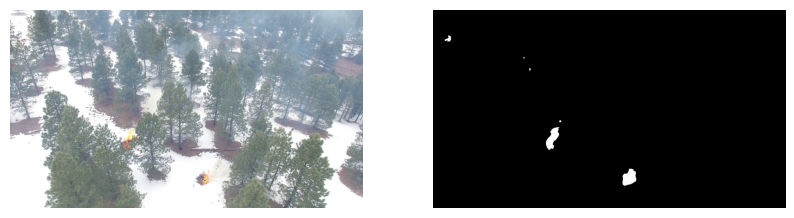

In [9]:
img, mask = dataset[0]
show(img, mask)

## Data Transforms

- see `DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1.transforms()`

```
SemanticSegmentation(
    resize_size=[520]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
```

In [13]:
preprocess = transforms.Compose([
    transforms.Resize(520, antialias=True),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

preprocess_mask = transforms.Compose([
    transforms.Resize(520, antialias=True)
])

In [14]:
dataset = FlameSegDataset(IMAGE_DIR, MASK_DIR, img_transform=preprocess, mask_transform=preprocess_mask)

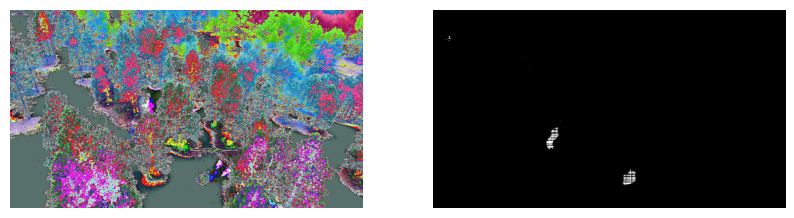

In [15]:
img, mask = dataset[0]
show(img, mask)

# Dataloader

In [16]:
BATCH_SIZE = 8
TRAIN_FRAC = 0.8

train, test = random_split(dataset, [TRAIN_FRAC, 1-TRAIN_FRAC], torch.Generator().manual_seed(10))

train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
print("Train Size:", len(train))
print("Test Size:", len(test))

Train Size: 1603
Test Size: 400


# deeplabv3_mobilenet_v3_large

In [19]:
class deeplabv3_mobilenet_v3_large_FLAME(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = deeplabv3_mobilenet_v3_large(weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1)

        for param in self.model.parameters():
            param.requires_grad = False
          
        for param in self.model.classifier.parameters():
            param.requires_grad = True

        self.model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x):
        return self.model(x)
    
    def predict(self, x):
        out = self.model(x)["out"]
        return torch.round(torch.sigmoid(out))

In [22]:
model = deeplabv3_mobilenet_v3_large_FLAME().to(device)

## Training

In [23]:
def plot_hist(train_loss):
    plt.figure(figsize=(10,5))
    plt.plot(train_loss)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

In [24]:
def train(model, dl, criterion, optim, epochs=2):
    train_loss = []

    for epoch in range(epochs):
        model.train()

        batch_loss = []
        progress_bar = Progbar(len(dl))

        for i, (x, y) in enumerate(dl):
            out = model(x)
            mask = out["out"]

            loss = criterion(mask, y)

            batch_loss.append(loss.item())

            optim.zero_grad()
            loss.backward()
            optim.step()

            progress_bar.update(i+1, [
                ("Epoch", epoch+1),
                ("Train Loss", loss.item()),
            ])

        epoch_loss = np.mean(np.array(batch_loss))
        train_loss.append(epoch_loss)

    return train_loss

In [25]:
lr = 1e-3
epochs = 5

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [26]:
hist = train(model, train_dl, criterion, optimizer, epochs=epochs)

201/201 [==============================] - 307s 2s/step - Epoch: 5.0000 - Train Loss: 0.0061


## Checkpoint

In [27]:
PATH = "deeplabv3_mobilenet_v3_large_FLAME.pt"

torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': hist[-1],
            }, PATH)

In [38]:
!gdown --folder 1CW4XCA0CYBCpXWWjjsOXkARh_qTWIG5s
clear_output()
PATH = "./Checkpoints/deeplabv3_mobilenet_v3_large_FLAME.pt"

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## Evaluation

### Visualizing Output

In [39]:
model.eval()
img, mask = dataset[0]
out = model.predict(img.unsqueeze(dim=0)).squeeze(dim=0)

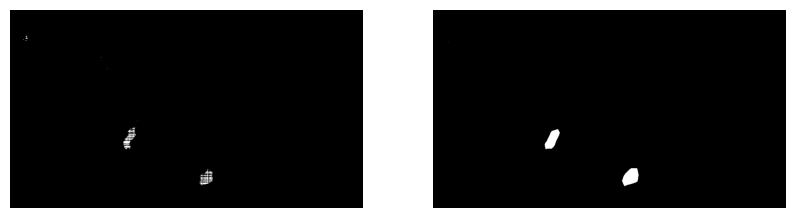

In [40]:
show(mask, out)

## Evaluation Functions

In [41]:
SMOOTH = 1e-6

@torch.no_grad()
def iou(outputs, labels):
    outputs = outputs.view(-1).type(torch.uint8)
    labels = labels.view(-1).type(torch.uint8)
    
    intersection = (outputs & labels).sum()
    union = (outputs | labels).sum()

    iou = (intersection + SMOOTH) / (union + SMOOTH)

    return torch.mean(iou).item()

In [42]:
@torch.no_grad()
def accuracy(output, target):
    output = output.view(-1)
    target = target.view(-1)

    correct_pixels = torch.sum(output == target).item()

    total_pixels = target.numel()

    accuracy = correct_pixels / total_pixels

    return accuracy

In [43]:
@torch.no_grad()
def evaluate(model, dl, metric_funcs={}):
    model.eval()
    metrics = {key: [] for key in metric_funcs}
    
    progress_bar = Progbar(len(dl))
    
    for i, (x, y) in enumerate(dl):
        pred = model.predict(x)
        
        for key, func in metric_funcs.items():
            value = func(pred, y)
            
            if type(value) not in [float, int]:
                raise Exception("Metric function must return a integer or a float")

            metrics[key].append(value)
        
        progress_bar.update(i+1, [(key, value[-1]) for key, value in metrics.items()])

    return {key: np.mean(np.array(value)) for key, value in metrics.items()}

In [44]:
metrics = evaluate(model, test_dl, {"accuracy": accuracy, "iou": iou})

50/50 [==============================] - 60s 1s/step - accuracy: 0.9935 - iou: 0.3486


## Accuracy

In [45]:
print("Accuracy", metrics["accuracy"])

Accuracy 0.9935432432151181


## IOU

In [46]:
print("IOU", metrics["iou"])

IOU 0.3486368775367737
